# 1. Dataset con círculos

In [1]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class CircleDataset(Dataset):
    def __init__(self, num_samples=1000, img_size=64):
        self.samples = []
        self.labels = []
        self.img_size = img_size

        for _ in range(num_samples):
            img = np.zeros((img_size, img_size), dtype=np.float32)

            # Centro aleatorio del círculo
            x = np.random.randint(8, img_size - 8)
            y = np.random.randint(8, img_size - 8)
            # radius = np.random.randint(3, 6)
            radius = 6

            # Dibujar el círculo
            cv2.circle(img, (x, y), radius, 1.0, -1)  # -1 = relleno

            self.samples.append(img)
            self.labels.append([x / img_size, y / img_size])  # Normalizado

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx][None, :, :]  # (1, H, W)
        label = self.labels[idx]
        return torch.tensor(img), torch.tensor(label, dtype=torch.float32)


# 2. Definir la Red Neuronal con ResNet-18

In [2]:
import torch.nn as nn
from torchvision import models

class ResNet18Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Adaptar la primera capa para imágenes en escala de grises (1 canal)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Reemplazar la capa final por una capa lineal que da 2 valores (x, y)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



# 3. Entrenamiento

In [3]:
import torch.optim as optim

# Inicializar dataset, dataloader y el modelo
dataset = CircleDataset(num_samples=1000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

model = ResNet18Regressor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Entrenamiento del modelo
for epoch in range(10):  # 10 épocas, puedes ajustar el número
    model.train()
    for imgs, labels in dataloader:
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")



/home/vpalazon/project/notebookenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vpalazon/project/notebookenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.0515
Epoch 2, Loss: 0.0362
Epoch 3, Loss: 0.0075
Epoch 4, Loss: 0.0070
Epoch 5, Loss: 0.0121
Epoch 6, Loss: 0.0205
Epoch 7, Loss: 0.0084
Epoch 8, Loss: 0.0025
Epoch 9, Loss: 0.0048
Epoch 10, Loss: 0.0015


# 4. Visualización de la predicción

/tmp/ipykernel_2563/3257056860.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_x, true_y = (np.array(test_label) * dataset.img_size).astype(int)


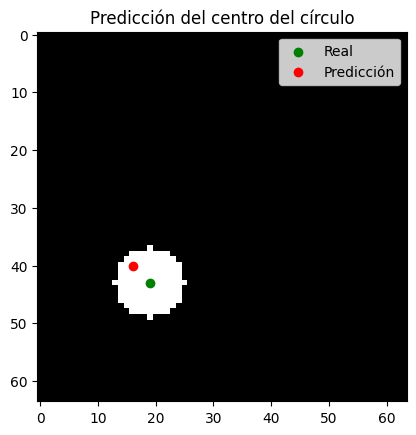

In [5]:
import matplotlib.pyplot as plt

# Tomar una imagen de prueba
test_img, test_label = dataset[0]
model.eval()
with torch.no_grad():
    pred = model(test_img.unsqueeze(0)).squeeze().numpy()

# Extraer coordenadas predichas y reales
img = test_img.squeeze().numpy()
pred_x, pred_y = (pred * dataset.img_size).astype(int)
true_x, true_y = (np.array(test_label) * dataset.img_size).astype(int)

# Mostrar imagen con las coordenadas reales y predichas
plt.imshow(img, cmap='gray')
plt.scatter([true_x], [true_y], c='green', label='Real')
plt.scatter([pred_x], [pred_y], c='red', label='Predicción')
plt.legend()
plt.title("Predicción del centro del círculo")
plt.show()